# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

(Inspired by "A Tutorial on Vanilla Bayesian Optimization" by Darian Nwankwo)

In [15]:
using Plots; plot() # warm start plotting engine
using LinearAlgebra
using Distributions
using Optim
using ForwardDiff

In [16]:
include("../src/testfns.jl")
include("../src/surrogates.jl")
include("../src/acquisitions.jl")

plotaf1d (generic function with 1 method)

In [17]:
include("../src/kernels.jl")

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed. Put these obervations into an nxd matrix X.

Test Function: GramacyLee


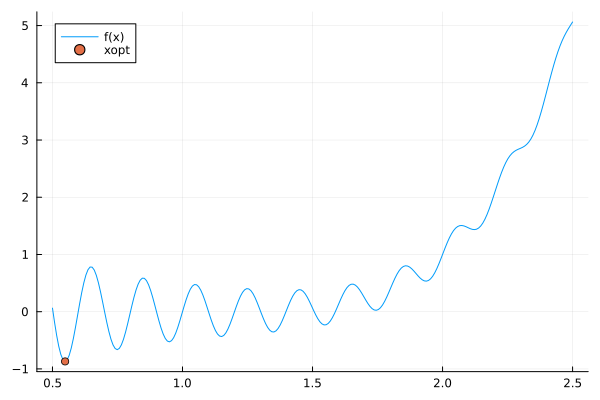

In [18]:
testfn, testfn_name, X, y =  get_toy_problem(N=100, fn_name = "GramacyLee")
println("Test Function: $(testfn_name)")
tplot(testfn)

## 2. Initialize surrogate model

Gather information regarding predictive mean and variance for our function. I will use kernels defined in kernels.jl.

In [19]:
#this will be changed so don't always
ψ = SquaredExponential(1.)

Kernel([1.0], var"#squared_exponential#587"{Float64}(1.0), var"#squared_exponential_hypers#588"(), var"#525#531"{var"#squared_exponential#587"{Float64}}(var"#squared_exponential#587"{Float64}(1.0)), var"#527#533"{var"#squared_exponential#587"{Float64}}(var"#squared_exponential#587"{Float64}(1.0)), var"#529#535"{Vector{Float64}, var"#squared_exponential_hypers#588"}([1.0], var"#squared_exponential_hypers#588"()), SquaredExponentialConstructor)

In [20]:
sur = GP(ψ, X, y, noise = 1e-6)

GaussianProcess(Kernel([1.0], var"#squared_exponential#587"{Float64}(1.0), var"#squared_exponential_hypers#588"(), var"#525#531"{var"#squared_exponential#587"{Float64}}(var"#squared_exponential#587"{Float64}(1.0)), var"#527#533"{var"#squared_exponential#587"{Float64}}(var"#squared_exponential#587"{Float64}(1.0)), var"#529#535"{Vector{Float64}, var"#squared_exponential_hypers#588"}([1.0], var"#squared_exponential_hypers#588"()), SquaredExponentialConstructor), [1.6240465300811717 2.2945411142650336 … 1.2019977560522526 0.8907980458205405], [1.000001 0.7986907186398534 … 0.9147883208264799 0.7642757162039613; 0.7986907186398534 1.000001 … 0.5505566097420848 0.3733468864223694; … ; 0.9147883208264799 0.5505566097420848 … 1.000001 0.9527310494231467; 0.7642757162039613 0.3733468864223694 … 0.9527310494231467 1.000001], [1.000000499999875 0.0 … 0.0 0.0; 0.7986903192947936 0.6017431128519715 … 0.0 0.0; … ; 0.9147878634326625 -0.29925660492644307 … 0.0010330436949712457 0.0; 0.764275334066389

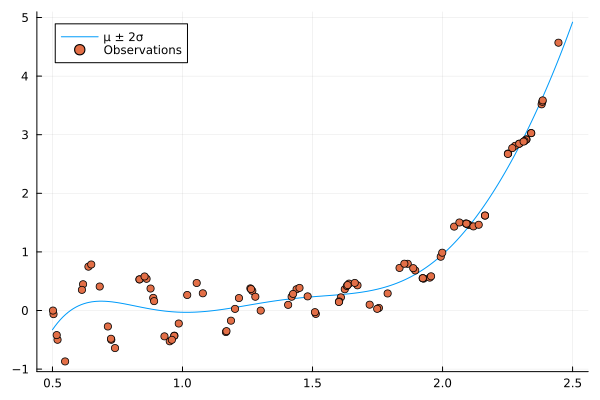

In [21]:
domain = first(testfn.bounds[:, 1]):0.01:first(testfn.bounds[:, 2])
plot1d(sur, interval = domain)

## 3. Construct Acquisition Function

Create some general acquisition functions for this step

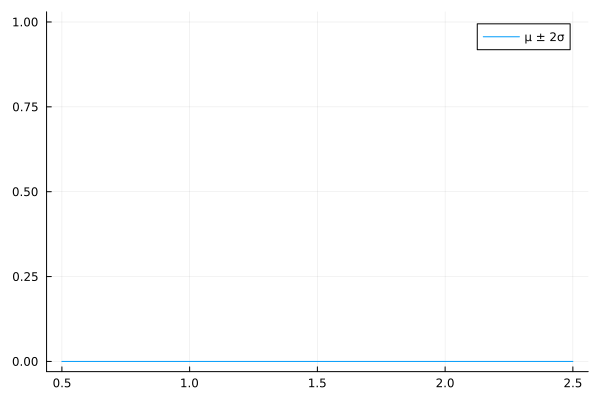

In [22]:
af, af_name = get_random_acquisitionfn(sur)
plotaf1d(af, interval = domain)

## 4. Optimize the acquisition function
Given our acquisition function, optimizing it directly. Thus, select the best location according to the chosen selection criteria.



In [23]:
function optimize_acquisition_functions(sur::GaussianProcess, X::Vector{Float64}, y::Vector{Float64})
    xopt = 1.0
    lb, ub = minimum(X), maximum(X)
    best_val = -Inf
    best_fn = ""

    for (fn_name, fn) in get_acquisition_functions(sur)
        res = optimize(
            x -> -fn.f(x),
            lb,
            ub
        )
        val = -Optim.minimum(res)  # Minimize negative to maximize
        if val > best_val
            best_val = val
            xopt = Optim.minimizer(res)[1]
            best_fn = fn_name
        end
    end

    println("Optimal x: ", xopt)
    println("Optimal value: ", best_val)
    println("Best acquisition function: ", best_fn)
    return xopt
end

optimize_acquisition_functions (generic function with 1 method)

In [24]:
X_vector = X[1, :]
optimize_acquisition_functions(sur, X_vector, y)

Optimal x: 1.2444042296701379
Optimal value: 0
Best acquisition function: Expected Improvement


1.2444042296701379

## 5. Sample data at new recommendation

In [27]:
# Referenced from Darian's code... still unsure about this part
xopt = optimize_acquisition_functions(sur, X_vector, y)
x_1, y_1 = xopt, testfn.f(xopt)
Xnew = hcat(sur.X, x_1)
ynew = vcat(y, y_1)

σ = sum(ynew)/length(ynew)
ynew = ynew .- σ

usur = fit_surrogate(ψ::RBFfun, Xnew, ynew)
θ, usur = optimize_hypers(ψ.θ, kernel, usur.X, usur.y);

Optimal x: 1.2444042296701379
Optimal value: 0
Best acquisition function: Expected Improvement


LoadError: UndefVarError: `RBFfun` not defined